In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

from utility import *

21/08/10 11:56:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/10 11:56:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/08/10 11:56:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
21/08/10 11:56:31 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
21/08/10 11:56:31 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [2]:
# Read in AP Data
df_ap = spark.read.csv('ap_data/18676_filtered_data_sample.csv', header=True, inferSchema=True, sep=",")
df_ap.limit(5).toPandas()

21/08/10 11:56:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,customer,id,erm__serial_number,AP Client Count Average,5 GHz Client Count Average,24 GHz Client Count Average,AP WAN TX Kbps Average,AP WAN TX Kbps Std Dev,AP WAN TX Kbps Max,AP WAN RX Kbps Average,...,Radio 24 tx_data_bytes Std Dev,Radio 24 tx_data_bytes Max,Radio 5 tx_data_packets Average,Radio 5 tx_data_packets Std Dev,Radio 5 tx_data_packets Max,Radio 24 tx_data_packets Average,Radio 24 tx_data_packets Std Dev,Radio 24 tx_data_packets Max,Radio 5 tx_dropped Average,sum
0,3b2ed110-59d9-11e9-b2eb-097690af9635,E43ED7D07707,J161103000272,0.556,0.693,1.0,27.0,0.000,27.0,0.0,...,0.0,26.000,0.000,1.091,-152.273,54.636,0.0,NaN,NaN,78
1,c45af140-2b6f-11ea-925c-cb4788700b86,F08620A246F4,J191009D00574,0.814,1.155,1.0,43.0,161.140,43.0,4102.0,...,0.0,42.000,0.000,2494.654,-156.885,72.962,0.0,NaN,NaN,74
2,5a4fe380-388d-11e9-88f4-6f9acfcffd90,D463FEE9EDBF,J160426003732,13.354,1.307,257.0,48.0,37.083,48.0,941.0,...,0.0,236.729,11922.521,684.083,1652.938,2725275.938,NaN,NaN,NaN,134
3,e36e7de0-c350-11e9-ac21-ad5d367e4a53,488D3601041C,J170308C00247,3.375,8.147,46.0,48.0,27.729,48.0,463.0,...,0.0,40.646,2275.750,155.521,331.146,38885.563,NaN,NaN,NaN,132
4,540c3bc0-fc4d-11e9-a5b9-2f5c5fe06d2e,F086202D902A,J190809D02739,3.479,8.551,109.0,48.0,15.479,48.0,504.0,...,0.0,48.000,0.000,126.792,-316.750,187.083,0.0,NaN,NaN,36


In [3]:
from pyspark.sql.functions import isnan, when, count, col, trim
# Fix Column Name Formatting
df_ap = df_ap.toDF(*(c.replace('.', '') for c in df_ap.columns)) 
# Get null value count for each column --> Drop rows will null values
df_ap.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ap.columns]).toPandas() 
# df_ap = df_ap.na.drop()

,customer,id,erm__serial_number,AP Client Count Average,5 GHz Client Count Average,24 GHz Client Count Average,AP WAN TX Kbps Average,AP WAN TX Kbps Std Dev,AP WAN TX Kbps Max,AP WAN RX Kbps Average,...,Radio 24 tx_data_bytes Std Dev,Radio 24 tx_data_bytes Max,Radio 5 tx_data_packets Average,Radio 5 tx_data_packets Std Dev,Radio 5 tx_data_packets Max,Radio 24 tx_data_packets Average,Radio 24 tx_data_packets Std Dev,Radio 24 tx_data_packets Max,Radio 5 tx_dropped Average,sum
0,0,0,0,0,126,125,1,1,1,1,...,1733,4722,4789,4836,7113,7113,16184,99993,99993,0


In [4]:
import pyspark.sql.functions as F

# Drop Columns with all null values
def drop_null_columns(df):
    
    _df_length = df.count()
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v >= _df_length]
    df = df.drop(*to_drop)
    
    return df

df_ap = drop_null_columns(df_ap)

In [5]:
# Read in Wifi-Data
df_wifi = spark.read.csv('Updated_WiFi_CIR/Updated WiFi_CIR_February_2021.csv', header=True, inferSchema=True, sep=",", nanValue=' ', nullValue=' ')

# Replace 'No' with None
df_wifi = df_wifi.na.replace('No', None)

In [6]:
# Update serial number column name before merging both data frames
df_ap = df_ap.withColumnRenamed('erm__serial_number', 'SERIAL_NO')

In [7]:
max_columns = [c for c in df_ap.columns if 'Max' in c]
average_columns = [c for c in df_ap.columns if 'Average' in c]
rate_average_columns = [c for c in df_ap.columns if 'Rate Average' in c]
std_columns = [c for c in df_ap.columns if 'Std Dev' in c]
total_columns = [c for c in df_ap.columns if 'Total' in c]
count_columns = [c for c in df_ap.columns if 'Count' in c]
count_average = [c for c in df_ap.columns if 'Count Average' in c]

In [8]:
wifi_columns = df_wifi.columns
wifi_columns.remove('AP_DEVICE_TYPE_NAME')
columns_to_drop = wifi_columns + ['customer', 'id'] + total_columns + count_columns + rate_average_columns 
columns_to_drop.remove('SERIAL_NO')

df = mergeDataFrames(df_ap, df_wifi, 'SERIAL_NO', columns_to_drop = columns_to_drop, withLabel = True)
df.limit(5).toPandas()

,SERIAL_NO,AP WAN TX Kbps Average,AP WAN TX Kbps Std Dev,AP WAN TX Kbps Max,AP WAN RX Kbps Average,AP WAN RX Kbps Std Dev,AP WAN RX Kbps Max,AP WAN Kbps Average,AP WAN Kbps Std Dev,AP WAN Kbps Max,...,Radio 5 tx_data_packets Average,Radio 5 tx_data_packets Std Dev,Radio 5 tx_data_packets Max,Radio 24 tx_data_packets Average,Radio 24 tx_data_packets Std Dev,Radio 24 tx_data_packets Max,Radio 5 tx_dropped Average,sum,AP_DEVICE_TYPE_NAME,label
0,J161103000272,27.0,0.000,27.0,0.0,0.000,0.0,0.741,20.0,0.00,...,0.000,1.091,-152.273,54.636,0.0,0.0,0.0,78,None,0
1,J191009D00574,43.0,161.140,43.0,4102.0,917.805,4261.0,0.000,0.0,0.00,...,0.000,2494.654,-156.885,72.962,0.0,0.0,0.0,74,None,0
2,J160426003732,48.0,37.083,48.0,941.0,930.022,953.0,0.000,0.0,0.00,...,11922.521,684.083,1652.938,2725275.938,0.0,0.0,0.0,134,None,0
3,J170308C00247,48.0,27.729,48.0,463.0,935.046,469.0,0.000,0.0,0.00,...,2275.750,155.521,331.146,38885.563,0.0,0.0,0.0,132,None,0
4,J190809D02739,48.0,15.479,48.0,504.0,938.546,514.0,106.438,5109.0,20801.75,...,0.000,126.792,-316.750,187.083,0.0,0.0,0.0,36,None,0


In [9]:
df_models = spark.read.csv('cluster_data/accesspoint_models.csv', header=True, inferSchema=True, sep=",", nanValue=' ', nullValue=' ')
df_models = df_models.withColumnRenamed('erm__serial_number', 'SERIAL_NO')
df = mergeDataFrames(df, df_models, 'SERIAL_NO', columns_to_drop = ['customer', 'id'], withLabel = False)

In [10]:
# df.filter('AP_DEVICE_TYPE_NAME is not null').limit(5).toPandas()
df.limit(5).toPandas()

,SERIAL_NO,AP WAN TX Kbps Average,AP WAN TX Kbps Std Dev,AP WAN TX Kbps Max,AP WAN RX Kbps Average,AP WAN RX Kbps Std Dev,AP WAN RX Kbps Max,AP WAN Kbps Average,AP WAN Kbps Std Dev,AP WAN Kbps Max,...,Radio 5 tx_data_packets Std Dev,Radio 5 tx_data_packets Max,Radio 24 tx_data_packets Average,Radio 24 tx_data_packets Std Dev,Radio 24 tx_data_packets Max,Radio 5 tx_dropped Average,sum,AP_DEVICE_TYPE_NAME,label,model
0,J151215000967,34.0,1230.941,34.0,2299.0,449211.991,2315.0,0.324,11.0,0.000,...,4014.061,-612.939,195.606,0.000,0.0,0.0,80,None,0,Singtel WiFi Gigabit Router AC Elite
1,J151217004840,48.0,45.792,48.0,351.0,841973.699,374.0,0.000,0.0,0.000,...,4098.375,518.125,0.000,79758.333,0.0,0.0,87,None,0,Singtel WiFi Gigabit Router AC Elite
2,J160205001938,48.0,70.167,48.0,327.0,933176.388,333.0,92.458,4438.0,5001.542,...,411.333,-1037.021,158.000,0.000,0.0,0.0,38,None,0,Singtel WiFi Gigabit Router AC Elite
3,J160414001895,48.0,207.229,48.0,918.0,1299821.478,924.0,28.000,1344.0,1813.021,...,69.917,-121.667,33.063,0.000,0.0,0.0,41,None,0,Singtel WiFi Gigabit Router AC Elite
4,J160414002698,34.0,359.853,34.0,2662.0,1703702.117,2713.0,1.441,49.0,52.000,...,914.029,-191.735,55.176,0.000,0.0,0.0,78,None,0,Singtel WiFi Gigabit Router AC Elite


In [11]:
df.groupBy('label').count().toPandas() 

,label,count
0,1,531
1,0,131104


In [12]:
correlatedFeatures = getCorrelation(df, df.columns[1:-2], threshold=0.5)

In [13]:
df = df.drop(*correlatedFeatures)

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

feature_columns = df.columns[1:-3]

assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")
scaler = StandardScaler(inputCol='features',outputCol='scaled_features')
minmaxScaler = MinMaxScaler(inputCol='features',outputCol='scaled_features')

kmeans = KMeans(featuresCol='scaled_features', k=2)

pipeline = Pipeline(stages=[assembler, minmaxScaler])
pipelineModel = pipeline.fit(df)

scaledDF = pipelineModel.transform(df)

kmModel = kmeans.fit(scaledDF)
results = kmModel.transform(scaledDF)

21/08/10 11:59:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/08/10 11:59:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [15]:
summary = kmModel.summary

In [16]:
results.groupBy('prediction').count().toPandas() 

,prediction,count
0,1,14138
1,0,117497


In [17]:
cluster0 = filterDataFrame(results, ['prediction == 0'])
cluster1 = filterDataFrame(results, ['prediction == 1'])

In [18]:
cluster0.groupBy('label').count().toPandas() 

,label,count
0,1,531
1,0,116966


In [19]:
cluster1.groupBy('label').count().toPandas() 

,label,count
0,0,14138


In [37]:
cluster0_data = [cluster0.filter('label == 0').count(), cluster1.filter('label == 0').count()]
cluster1_data = [cluster0.filter('label == 1').count(), cluster1.filter('label == 1').count()]

/var/folders/yn/m0pbsyzn6kz3jdnb9f75twwr0000gp/T/ipykernel_7700/2080514427.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png') #svg


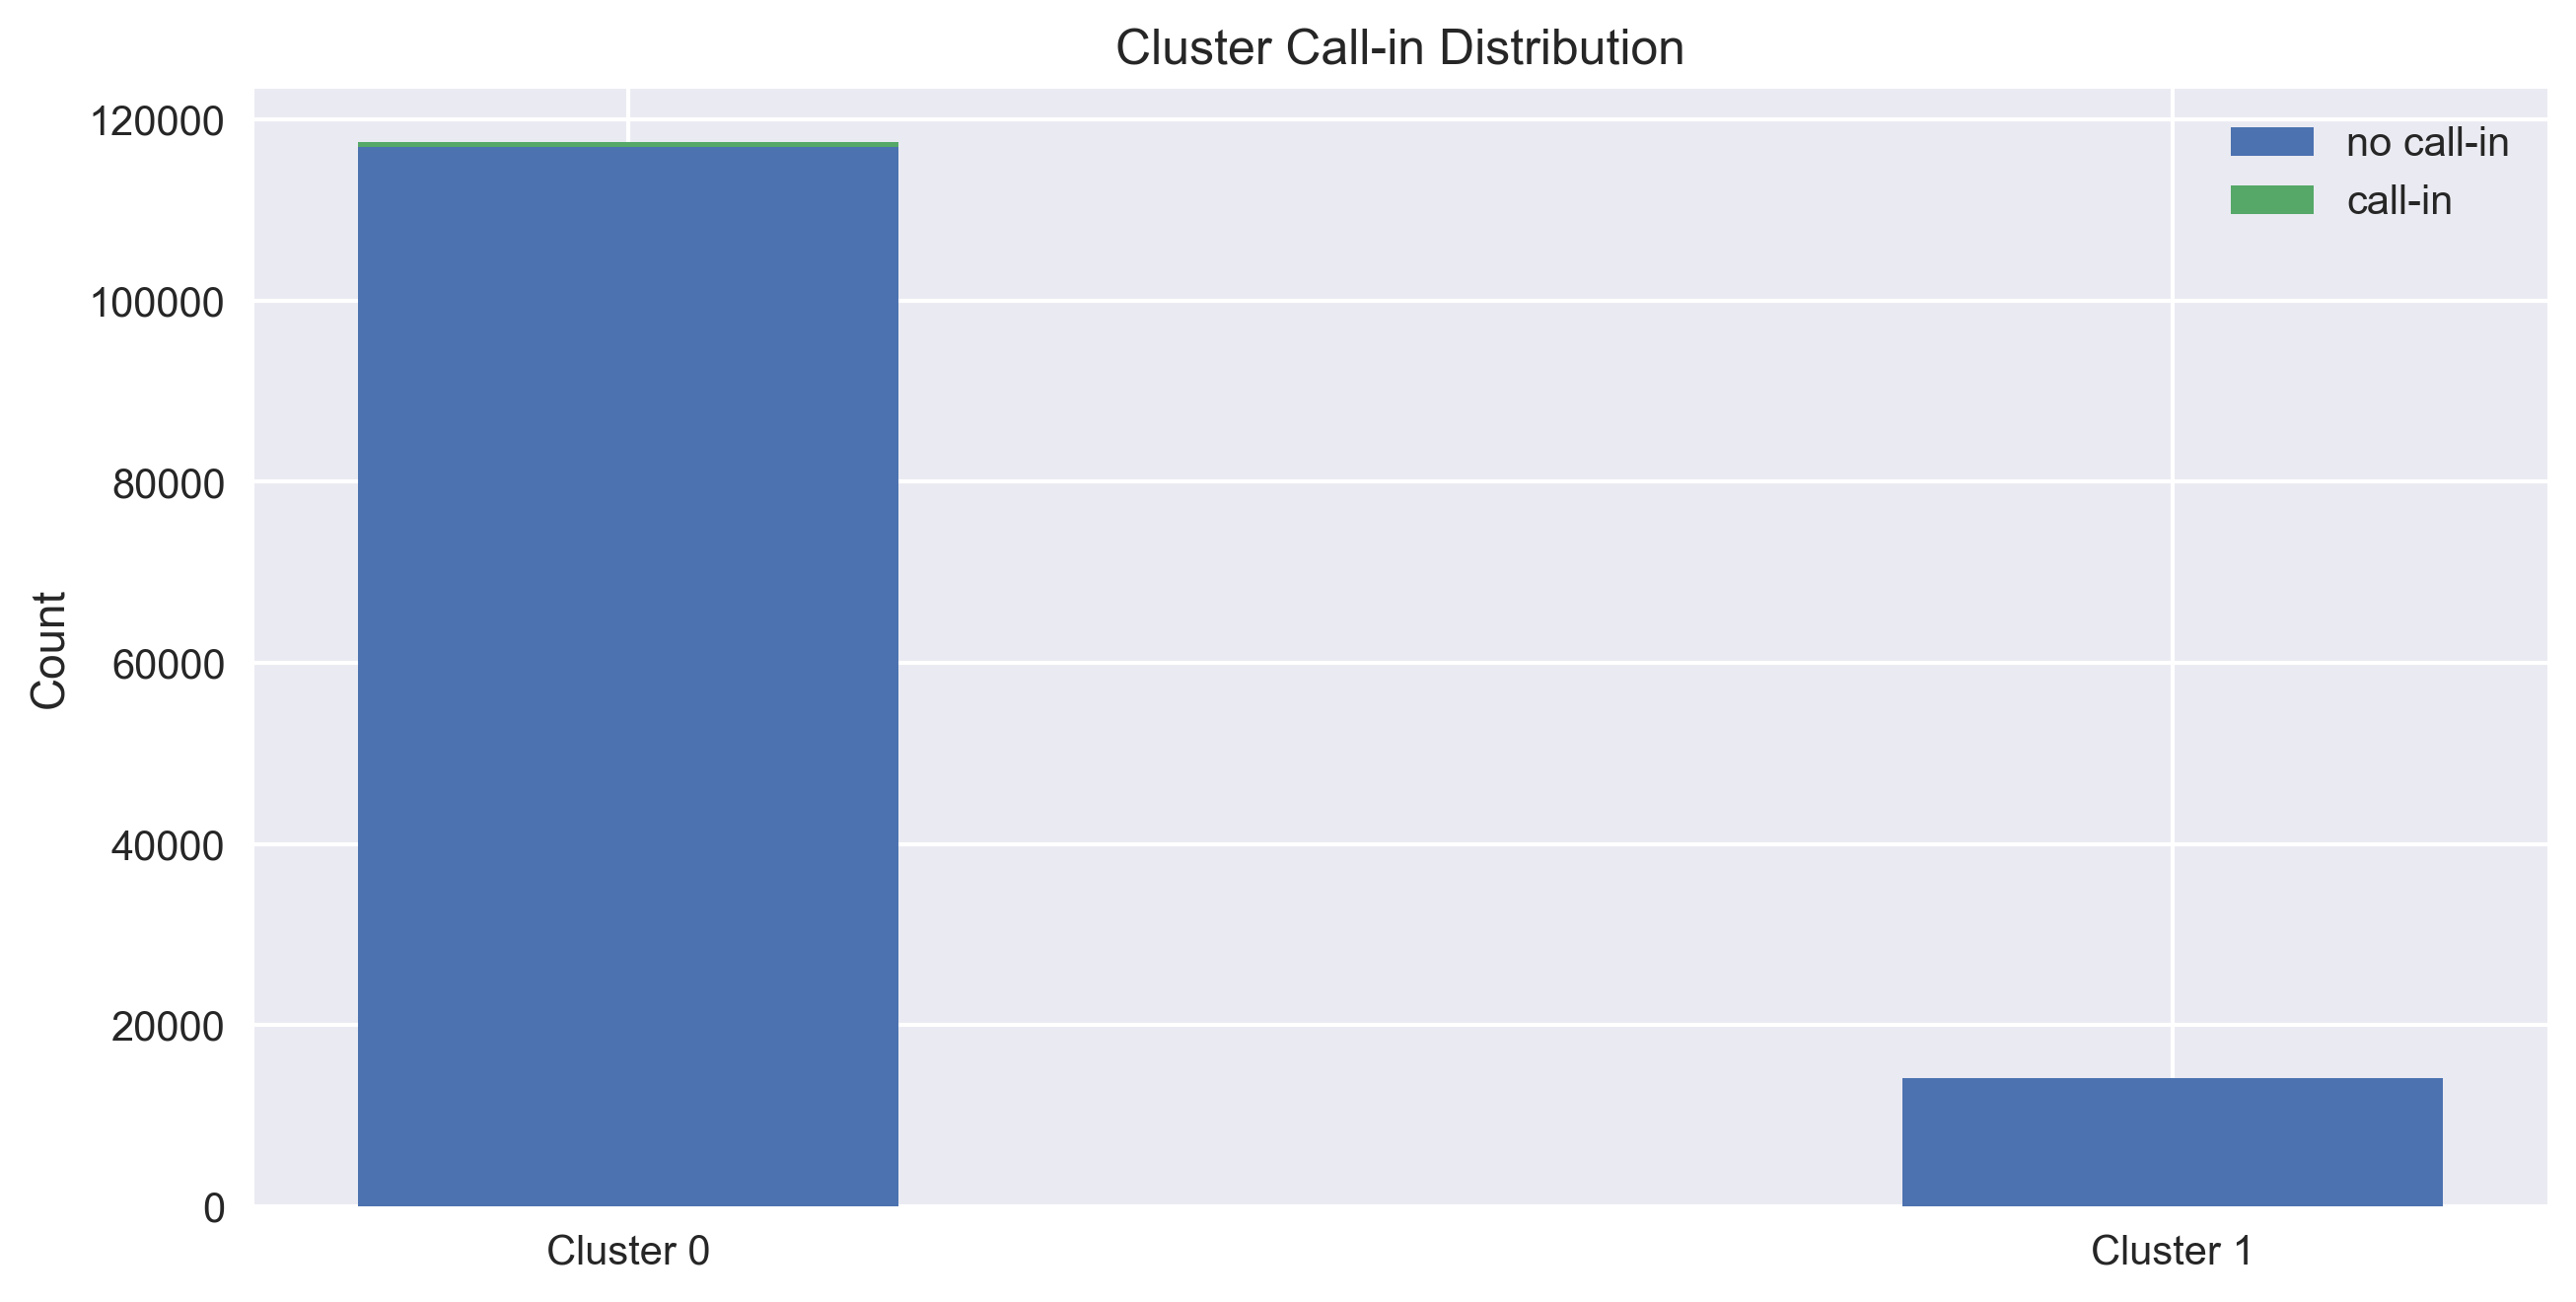

In [50]:
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') #svg
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

f, ax1 = plt.subplots(figsize=(10,5))

labels = ['Cluster 0', 'Cluster 1']
x = np.arange(len(labels))  # the label locations
width = 0.35

## Absolute count
plt.style.use('seaborn')
ax1.bar(labels, cluster0_data, width, label='no call-in')
ax1.bar(labels, cluster1_data, width, bottom=cluster0_data, label='call-in')
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title('Cluster Call-in Distribution')
ax1.legend()

plt.show()

In [29]:
getNumericalValues(cluster0, cluster0.columns[1:-6])

,summary,AP WAN TX Kbps Average,AP WAN TX Kbps Std Dev,AP WAN RX Kbps Average,AP WAN RX Kbps Std Dev,AP WAN Kbps Max,AP active_steer_attempts Average,AP active_steer_success Max,AP bandsteered_clients Average,AP client_connection_time Std Dev,...,Radio 5 tx_data_bytes Std Dev,Radio 5 tx_data_bytes Max,Radio 24 tx_data_bytes Average,Radio 24 tx_data_bytes Std Dev,Radio 24 tx_data_bytes Max,Radio 5 tx_data_packets Average,Radio 5 tx_data_packets Std Dev,Radio 5 tx_data_packets Max,Radio 24 tx_data_packets Average,Radio 24 tx_data_packets Std Dev
0,count,117497,117497,117497,117497,117497,117497,117497,117497,117497,...,117497,117497,117497,117497,117497,117497,117497,117497,117497,117497
1,mean,41.68780479501604,512.8594536456246,20114.435982901705,1376505.6820758856,5506.799383073611,1123.7555161238158,2.5916406376333016E-4,6.808684477050478E-5,68.02181222499304,...,6.680898584644715,5.125010110896448,118.05655840574651,44.844988697583744,219.5563371745661,682.2919521689906,3516.5656066878296,-97.88464442496407,31869.2290986153,38203.79043299833
2,stddev,16.347783779949822,3596.613974448566,168303.3295132624,1366008.4129227798,34222.46780675977,6656.529595980255,0.03087529651243037,0.01237707835924053,186.01313857352665,...,60.94353858244143,282.0043729927985,6868.371002232142,2919.9670747294135,36172.12550373037,8948.376088088642,320780.81544078724,1038.9987507223548,439674.58281084534,1126109.2437537452
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-759.917,-1323.813,-1428.25,-1569.897,-1950.396,0.0,0.0,-5184.833,0.0,0.0
4,max,142.0,1192604.19,4046930.498,1.0056825307E7,2519241.604,436667.0,4.243,3.0,4013.0,...,6840.229,59443.409,1095579.854,665167.813,1.2004164417E7,1037222.667,1.02629333667E8,274346.426,3.5338503708E7,1.24152465688E8


In [30]:
getNumericalValues(cluster1, cluster1.columns[1:-6])

,summary,AP WAN TX Kbps Average,AP WAN TX Kbps Std Dev,AP WAN RX Kbps Average,AP WAN RX Kbps Std Dev,AP WAN Kbps Max,AP active_steer_attempts Average,AP active_steer_success Max,AP bandsteered_clients Average,AP client_connection_time Std Dev,...,Radio 5 tx_data_bytes Std Dev,Radio 5 tx_data_bytes Max,Radio 24 tx_data_bytes Average,Radio 24 tx_data_bytes Std Dev,Radio 24 tx_data_bytes Max,Radio 5 tx_data_packets Average,Radio 5 tx_data_packets Std Dev,Radio 5 tx_data_packets Max,Radio 24 tx_data_packets Average,Radio 24 tx_data_packets Std Dev
0,count,14138,14138,14138,14138,14138,14138,14138,14138,14138,...,14138,14138,14138,14138,14138,14138,14138,14138,14138,14138
1,mean,71.37353232423257,71.37353232423257,8325631.665529383,1.000282925449144,0.0,680.9047405573631,0.0,0.0,7.523412080916678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,stddev,159.65073961606296,159.65073961606296,1488403.9784945003,0.026594804063639548,0.0,37265.53436097688,0.0,0.0,7.684044915846262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,min,0.0,0.0,4252837.451,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,969.0,969.0,1.0112846678E7,4.0,0.0,2575460.449,0.0,0.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in range(2,10):
    
    kmeans = KMeans(featuresCol='scaled_features', k=k)
    kmModel = kmeans.fit(scaledDF)
    output = kmModel.transform(scaledDF)
    
    score = evaluator.evaluate(output)
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.8848001073528811


Silhouette Score: 0.8049428522506147


Silhouette Score: 0.7281370838689796


Silhouette Score: 0.6971654277177478


Silhouette Score: 0.7101454441758905


Silhouette Score: 0.5479860993392935


Silhouette Score: 0.5774324849092348


Silhouette Score: 0.5991343892860902


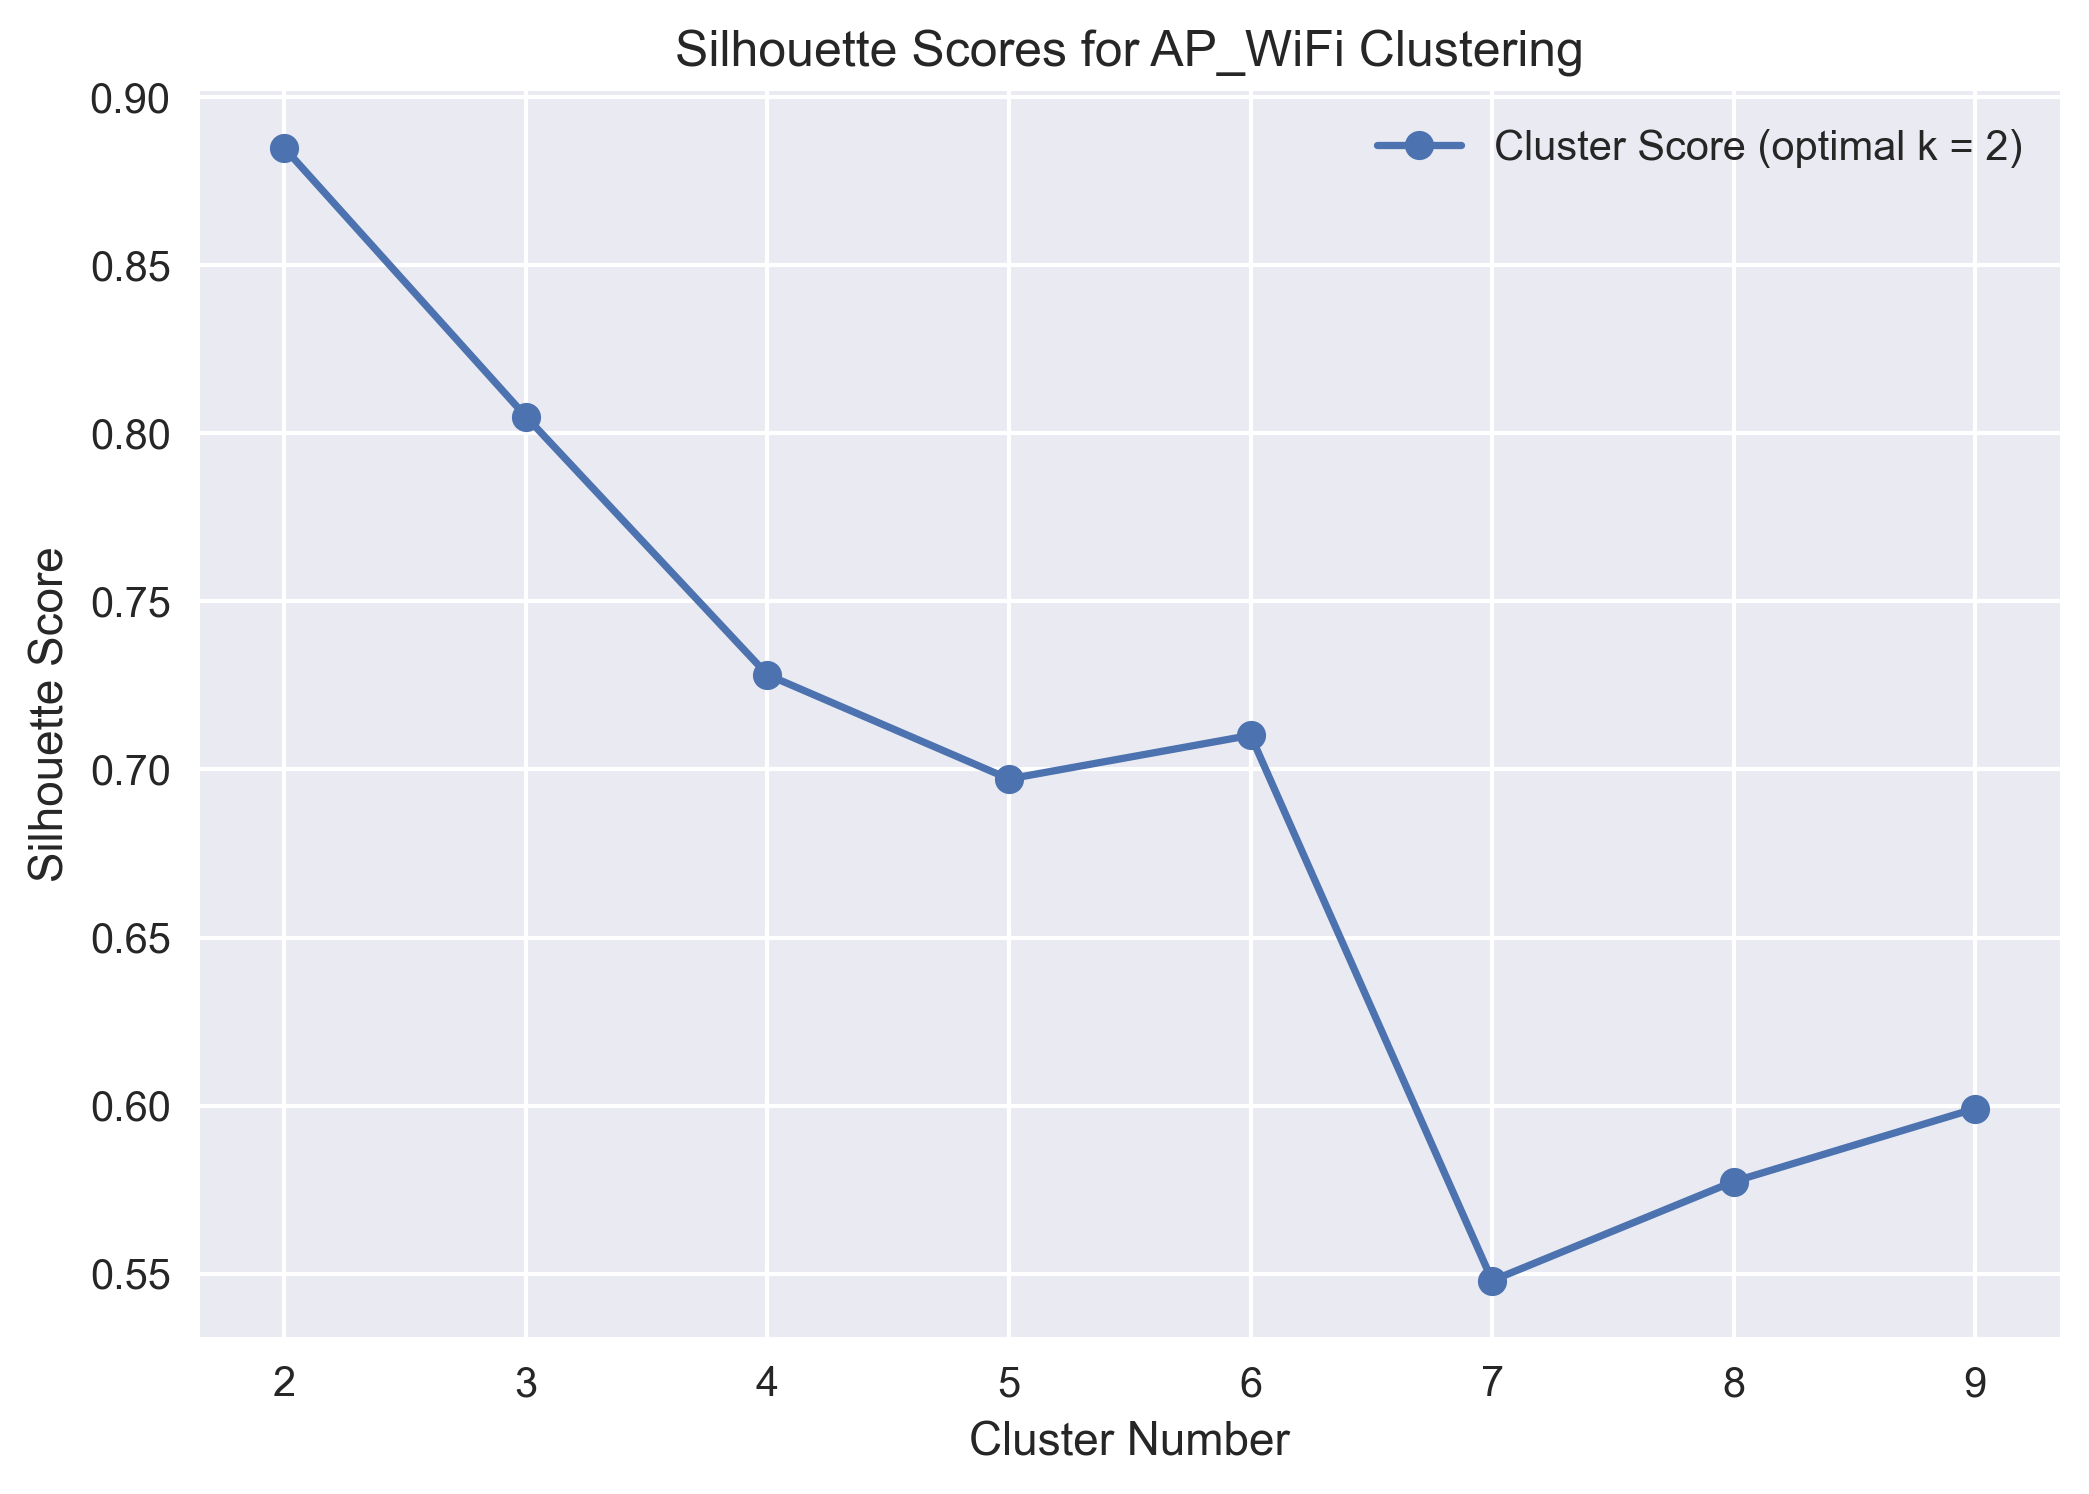

In [55]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.title('Silhouette Scores for AP_WiFi Clustering')
plt.xlabel('Cluster Number')
plt.ylabel('Silhouette Score')
plt.plot(range(2,10), silhouette_score, marker = 'o', label = 'Cluster Score (optimal k = 2)')
plt.legend()
